In [56]:
## import the required package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch as t
import torch.nn as nn
from torch.nn import functional as F
import re

## Data Description

The data contains the crimial history jail and prison time, demographics and COMPAS risk scores for defendants from Broward County from 2013 to 2014. The dataset we are using is compas-scores-two-years.csv.

In [74]:
## Read the file
df = pd.read_csv("/content/compas-scores-two-years.csv")

## Filter the data
df = df[(df["race"] == "African-American") | (df["race"] == "Caucasian")]

## Change the race entry
df["race"] = np.where(df["race"] == "African-American", 0, 1)

## We drop attributes that is clearly independent with the two_year_recid, ie. name, id, r_case_number, c_case_number,
## as well as the attribute with all NaN value
## as well as the duplicate columns
df.drop(["id", "name", "first", "last", "r_case_number", "c_case_number",
         "violent_recid",
         "decile_score.1", "priors_count.1"],
        axis = 1, inplace=True)

In [75]:
## We drop the column with the number of NaN value exceed 1000
df.drop(["vr_charge_desc", "vr_offense_date",
        "vr_charge_degree", "vr_case_number", "c_arrest_date",
        "c_arrest_date", "r_jail_out", "r_jail_in", "r_days_from_arrest",
        "r_charge_desc", "r_charge_degree", "r_offense_date"],
        axis = 1, inplace=True)

## Remove the rows with NaN
df.dropna(inplace=True)

## we also drop the columns represent the date
df.drop(['compas_screening_date', 'dob', 'c_jail_in', 'c_jail_out',
         'c_offense_date', 'screening_date', 'v_screening_date',
         'in_custody', 'out_custody', 'days_b_screening_arrest'],
        axis = 1, inplace=True)

## We drop the somehow repeated attribute, age_cat, score_text, v_score_text
df.drop(['age_cat', 'score_text', 'v_score_text', 'is_recid', "v_decile_score"],
        axis = 1, inplace=True)

## Set sex into 0 or 1, c_charge_degree into 0 or 1
df["sex"] = np.where(df["sex"] == "Male", 0, 1)
df["c_charge_degree"] = np.where(df["c_charge_degree"] == "M", 0, 1)

## Drop the column with only 1 input or too many category
df.drop(['type_of_assessment', 'v_type_of_assessment', 'c_charge_desc'],
        axis = 1, inplace=True)

In [76]:
df.head(5)

,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_days_from_compas,c_charge_degree,is_violent_recid,start,end,event,two_year_recid
1,0,34,0,0,3,0,0,0,1.0,1,1,9,159,1,1
2,0,24,0,0,4,0,1,4,1.0,1,0,0,63,0,1
6,0,41,1,0,6,0,0,14,1.0,1,0,5,40,1,1
8,1,39,1,0,1,0,0,0,1.0,0,0,2,747,0,0
9,0,21,1,0,3,0,0,1,308.0,1,1,0,428,1,1


## Baseline Model

In [88]:
scaler = StandardScaler()
X, y = df.drop("two_year_recid", axis = 1, inplace = False), df.two_year_recid
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=5243)


baseline = LogisticRegression(random_state=5243,max_iter=1000)

baseline.fit(X_train, y_train)
preds = baseline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

preds_all = baseline.predict(X_test)
accuracy_base = sum(y_test == preds_all)/len(y_test)
print("Accuracy: %f" % (accuracy_base))

RMSE: 0.264840
Accuracy: 0.929860


## Paper 5: Fairness-aware Classifier with Prejudice Remover Regularizer

This paper introduces a fairness-aware classification method that addresses discrimination in automated decisions by introducing a **prejudice remover regularizer**.

The paper identifies three main causes of unfairness in machine learning:
- prejudice,
- underestimation, and
- negative legacy.

The proposed regularization approach, applicable to any probabilistic discriminative model, aims to **mitigate indirect prejudice—bias not directly related to sensitive features but still affecting decisions**.

### Baseline model (logistic regression model)

$\mathcal{M}[y|\mbox{x},s;\Theta]=y\sigma(\mbox{x}^T\mbox{w}_s)+(1-y)(1-\sigma(\mbox{x}^T\mbox{w}_s))$

objective function to minimize:

$-\mathcal{L}(\mathcal{D};\Theta)+\eta \mathcal{R}(\mathcal{D};\Theta)+\frac{\lambda}{2}\|\Theta\|^2_2$

### Baseline model with prejudice remover regularize:

$\sum_{(\mathcal{x}_is_i)\in\mathcal{D}}\sum_{y\in\{0,1\}}\mathcal{M}[y|\mbox{x}_i,s_i;\Theta]\ln\frac{\hat{\Pr}[y|s_i]}{\hat{\Pr}[y]}$

Where:

$\hat{\Pr}[y|s_i]\approx\frac{\sum_{(\mathcal{x}_is_i)\in\mathcal{D}\textit{ s.t. }s_i=s}\mathcal{M}[y|\mbox{x}_i,s_i;\Theta]}{|\{(\mathcal{x}_i,s_i)\in\mathcal{D}\textit{ s.t. }s_i=s\}|}$

$\hat{\Pr}[y]\approx\frac{\sum_{(\mathcal{x}_is_i)\in\mathcal{D}}\mathcal{M}[y|\mbox{x}_i,s_i;\Theta]}{|\mathcal{D}|}$

In [92]:
#1
df_1 = df.loc[df['two_year_recid']==1]
X_1, y_1 = df_1.drop("two_year_recid", axis = 1, inplace = False), df_1.two_year_recid
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=5243)

x_1 = t.from_numpy(np.array(X_train_1)).to(t.float32)
y_1 = t.from_numpy(np.array(y_train_1).astype('float32')).reshape(x_1.shape[0],1)

x_test_1 = t.from_numpy(np.array(X_test_1)).to(t.float32)
y_test_1 = t.from_numpy(np.array(y_test_1).astype('float32')).reshape(x_test_1.shape[0],1)

#0
df_0 = df.loc[df['two_year_recid']==0]
X_0, y_0 = df_0.drop("two_year_recid", axis = 1, inplace = False), df_0.two_year_recid
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, test_size=0.2, random_state=5243)

x_0 = t.from_numpy(np.array(X_train_0)).to(t.float32)
y_0 = t.from_numpy(np.array(y_train_0).astype('float32')).reshape(x_0.shape[0],1)

x_test_0 = t.from_numpy(np.array(X_test_0)).to(t.float32)
y_test_0 = t.from_numpy(np.array(y_test_0).astype('float32')).reshape(x_test_0.shape[0],1)

In [93]:
x_0

tensor([[  1.,  28.,   1.,  ...,  44., 792.,   0.],
        [  1.,  54.,   1.,  ...,   0., 921.,   0.],
        [  1.,  25.,   1.,  ...,   0., 827.,   0.],
        ...,
        [  1.,  20.,   1.,  ...,   0., 921.,   0.],
        [  0.,  25.,   0.,  ...,   1., 758.,   0.],
        [  0.,  23.,   0.,  ...,   0., 870.,   0.]])

In [94]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        # out_features is the number of outputs. I don't use bias here because the constant dimension in x already introduced the bias term in W.
        self.w = nn.Linear(x_1.shape[1], out_features=1, bias=True)
        self.sigmod = nn.Sigmoid()
    def forward(self,x):
        # For the torch.nn.NLLLoss, the first input is the "log probability",log_softmax? log sigmod(binary).
        w = self.w(x)
        output = self.sigmod(w)
        return output

In [95]:
class PRLoss():#using linear
    def __init__(self, eta=1.0):
        super(PRLoss, self).__init__()
        self.eta = eta
    def forward(self,output_1,output_0):
        # For the mutual information,
        # Pr[y|s] = sum{(xi,si),si=s} sigma(xi,si) / #D[xs]
        #D[xs]
        N_1 = t.tensor(output_1.shape[0])
        N_0   = t.tensor(output_0.shape[0])
        Dxisi = t.stack((N_0,N_1),axis=0)
        # Pr[y|s]
        y_pred_1 = t.sum(output_1)
        y_pred_0   = t.sum(output_0)
        P_ys = t.stack((y_pred_0,y_pred_1),axis=0) / Dxisi
        # Pr[y]
        P = t.cat((output_1,output_0),0)
        P_y = t.sum(P) / (x_1.shape[0]+x_0.shape[0])
        # P(siyi)
        P_s1y1 = t.log(P_ys[1]) - t.log(P_y)
        P_s1y0 = t.log(1-P_ys[1]) - t.log(1-P_y)
        P_s0y1 = t.log(P_ys[0]) - t.log(P_y)
        P_s0y0 = t.log(1-P_ys[0]) - t.log(1-P_y)
        # PI
        PI_s1y1 = output_1 * P_s1y1
        PI_s1y0 =(1- output_1) * P_s1y0
        PI_s0y1 = output_0 * P_s0y1
        PI_s0y0 = (1- output_0 )* P_s0y0
        PI = t.sum(PI_s1y1) + t.sum(PI_s1y0) + t.sum(PI_s0y1) + t.sum(PI_s0y0)
        PI = self.eta * PI
        return PI

In [96]:
def accuracy( Model_1,Model_0, x_1, y_1,x_0,y_0):
    y1_pred = (Model_1(x_1) >= 0.5)
    y0_pred = (Model_0(x_0) >= 0.5)
    accu_1  = t.sum(y1_pred.flatten() == y_1.flatten()) / x_1.shape[0]
    accu_0  = t.sum(y0_pred.flatten() == y_0.flatten()) / x_0.shape[0]
    accuracy = (accu_1 + accu_0) / 2
    return round(accuracy.item(),4)
    print("Accuracy : %.3f" % (accuracy * 100)+'%')

In [97]:
class PRLR():#using linear
    def __init__(self, eta=0.0,epochs = 3000,lr = 0.01):
        super(PRLR, self).__init__()
        self.eta = eta
        self.epochs = epochs
        self.lr = lr
    def fit(self,x_1,y_1,x_0,y_0,x_test_1,y_test_1,x_test_0,y_test_0):
        model_1 = LogisticRegression()
        model_0 = LogisticRegression()
        criterion = nn.BCELoss(reduction='sum')
        PI = PRLoss(eta=self.eta)
        epochs = self.epochs
        optimizer = t.optim.Adam(list(model_1.parameters())+ list(model_0.parameters()), self.lr, weight_decay=1e-5)
        for epoch in range(epochs):
            optimizer.zero_grad()
            output_1 = model_1(x_1)
            output_0 = model_0(x_0)
            logloss = criterion(output_1, y_1)+ criterion(output_0, y_0)
            PIloss = PI.forward(output_1,output_0)
            loss = PIloss +logloss
            loss.backward()
            optimizer.step()
        model_1.eval()
        model_0.eval()
        accu = accuracy(model_1,model_0,x_test_1,y_test_1,x_test_0,y_test_0)
        return accu

In [98]:
PR = PRLR(eta = 1.0, epochs = 1000, lr = 0.01)

accv=t.tensor(PR.fit(x_1,y_1,x_0,y_0,x_test_1,y_test_1,x_test_0,y_test_0))
print("accuracy:",float(accv))

accuracy: 0.9943000078201294


## Paper 6: Handling Conditional Discrimination

This paper handle with discrimination introduced by sensitive parameter, here "race".

### Background

The bias that caused by discrimination can be distribute to two part:
- discrimination caused by the sensitive attribute itself $D_{bad}$
- the discrimination caused by the attributes that are correlated to the sensitive attribute $D_{expl}$.

*Notice* : the attribute that are correlated to the sensitive attribute and also gives some objective information to the label y is called **explanatory attribute**.

In summary, $D_{all}=D_{bad}+D_{expl}$.

### Objective of the paper

- minimize the absolute value of $D_{bad}$
- keeping the accuracy as high as possible

### Method

To be discrimination free, we should control:
- $P_c(+|e_i, race = 0) = P_c(+|e_i, race = 1)$, where $e_i$ is the explanatory attribute and $P(+)=P(y=+1)$
- $P_c(+|e_i) = P_c^\star(+|e_i)$, where $P_c^\star(+|e_i):=\frac{P_c(+|e_i, race=1)+P_c(+|e_i, race=0)}{2}$

To achieve it, the paper introduced two methods: Local Massaging and Local Preferential Sampling.

###  *Local Massaging*

Modify the value of y until $P_c'(+|e_i, race = 0)=P_c'(+|e_i, race = 1)=P_c^\star(+|e_i)$ by identifing the instances that are close to the decision boundary and changes the values of their labels to the opposite.

Convert the original binary label y into real valued probabilities of defendant recidivated within two year, and sort the value. Change the lable of individuals that are almost recidivated within two year or almost not recidivated within two year to opposite.

### *Local Preferential Sampling*

This method modifies the composition of the training set. It deletes and duplicates training instances such that the modified training set satisty $P_c'(+|e_i, race = 0)=P_c'(+|e_i, race = 1)=P_c^\star(+|e_i)$.

To achieve it, it deletes the ‘wrong’ instances that are close to the decision boundary and duplicates the instances that are ‘right’ and close to the boundary.

In [78]:
## Calculate D_{all}
def D_all_func(data = df):
  P_y1r1 = len(data[(data["two_year_recid"] == 1) & (data["race"] == 1)])/len(data[data['race'] == 1])
  P_y1r0 = len(data[(data["two_year_recid"] == 1) & (data["race"] == 0)])/len(data[data['race'] == 0])
  D_all = P_y1r0-P_y1r1
  return(D_all)

D_all_base = D_all_func()
D_all_base

0.13598888652499458

In [79]:
expl = ['sex', 'age', 'juv_fel_count', 'decile_score', 'juv_misd_count',
       'juv_other_count', 'priors_count',
       'c_days_from_compas', 'c_charge_degree', 'is_violent_recid', 'start', 'end', 'event']

## Calculate D_bad
def D_bad_func(data = df, y_col = "two_year_recid", expl_col = expl, D_all = D_all_base):

  '''
  This function take a data frame, the name of the y column and a list of explanatory attribute as input
  Then output a dictionary of D_{expl}
  '''

  D_bad = dict()
  for i in expl_col:
    P_star_i = data.groupby(['race', i])[y_col].mean().unstack(fill_value=0).mean()
    expl_counts = data.groupby(['race', i]).size().unstack(fill_value=0)
    race_counts = data['race'].value_counts()
    P_e_r = expl_counts.div(race_counts, axis=0)
    P_e_r_diff =  P_e_r.loc[0] - P_e_r.loc[1]
    D_bad_i = D_all - (P_e_r_diff * P_star_i).sum()
    D_bad[i] = D_bad_i

  return(D_bad)

D_bad_baseline = D_bad_func()

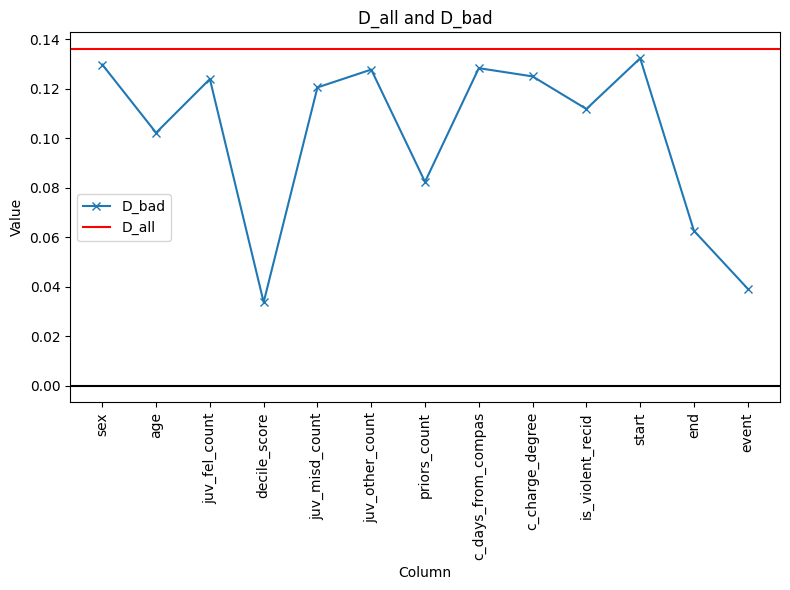

In [80]:
## Plot the graph of D_{all} and D_{bad}
def plot_D(D_bad, D_all):
  df_plot = pd.DataFrame({
      'Column': D_bad.keys(),
      'D_bad': D_bad.values()
  })
  plt.figure(figsize=(8, 6))

  # Plot D_{expl} and D_{all}
  plt.plot(df_plot['Column'], df_plot['D_bad'], marker='x', label='D_bad')
  plt.axhline(y=D_all, color='r', linestyle='-', label='D_all')
  plt.axhline(y=0, color='black', linestyle='-')
  plt.title('D_all and D_bad')
  plt.xlabel('Column')
  plt.ylabel('Value')
  plt.xticks(rotation=90)
  plt.legend()
  plt.tight_layout()
  plt.show()

plot_D(D_bad_baseline, D_all_base)

As we can see on the plot, `decile_score` have the highest $D_{expl}$ in absolute value. Hence, we will use `decile_score` as the explanatory attribute.

In [81]:
# define attributes
explanatory_attribute = 'decile_score'
sensitive_attribute = 'race'
target = 'two_year_recid'

In [82]:
def LocalMethod(df = df, sensitive_attr = sensitive_attribute,
                explanatory_attr = explanatory_attribute, target = target):
  '''
  This function take a data frame, the sensitive attribute,
  the explanatory attribute and the y_label as input

  Then output two data frame that corresponding to the data
  modified by LocalMassaging and LocalPreferential
  '''

  df_massaged = df.copy() # avoid changing originial dataframe
  df_preferential = df.copy()

  # Calculate P*
  P_star = df_massaged.groupby(explanatory_attr)[target].mean().mean()

  # Calculate the acceptance rate for each group
  acceptance_rates = df_massaged.groupby([sensitive_attr, explanatory_attr])[target].mean()

  # For each group within the explanatory subset, adjust labels to match P*
  for (sens_value, expl_value), group_df in df_massaged.groupby([sensitive_attr, explanatory_attr]):

      # Calculate the number of labels that need to be changed
      current_rate = acceptance_rates[sens_value, expl_value]
      num_to_change = int(abs(current_rate - P_star) * len(group_df))
      num_to_change_p = int(1/2 * abs(current_rate - P_star) * len(group_df))

      if num_to_change == 0:
          continue

      X_race = group_df.drop(target, axis = 1, inplace = False)
      X_race_scaled = scaler.fit_transform(X_race)
      ## Learn a ranker
      ranker = LogisticRegression(random_state=5243,max_iter=200)

      ranker.fit(X_race_scaled, group_df.two_year_recid)
      group_df['rank'] = ranker.predict_proba(X_race_scaled)[:, 1]

      # Sort the individuals based on closeness to decision boundary
      group_df_sorted = group_df.sort_values(by='rank', ascending=False)
      group_indices = group_df_sorted.index

      ## partition different label to two group
      label_0 = group_df_sorted[group_df_sorted[target] == 0]
      label_1 = group_df_sorted[group_df_sorted[target] == 1]

      cloest_1_but_0 = label_0.head(num_to_change_p).drop(columns = 'rank')
      cloest_0_but_1 = label_1.tail(num_to_change_p).drop(columns = 'rank')

      if current_rate > P_star:
          # Modifies the dataset
          change_indices = label_1.head(num_to_change).index
          df_massaged.loc[change_indices, target] = 0
          df_preferential.drop(cloest_0_but_1.index, inplace = True)
          df_preferential = pd.concat([df_preferential, cloest_1_but_0], ignore_index=False)
      else:
          change_indices = label_0.head(num_to_change).index
          df_massaged.loc[change_indices, target] = 1
          df_preferential.drop(cloest_1_but_0.index, inplace = True)
          df_preferential = pd.concat([df_preferential, cloest_0_but_1], ignore_index=False)

  return df_massaged, df_preferential

In [83]:
df_lm, df_lp = LocalMethod()

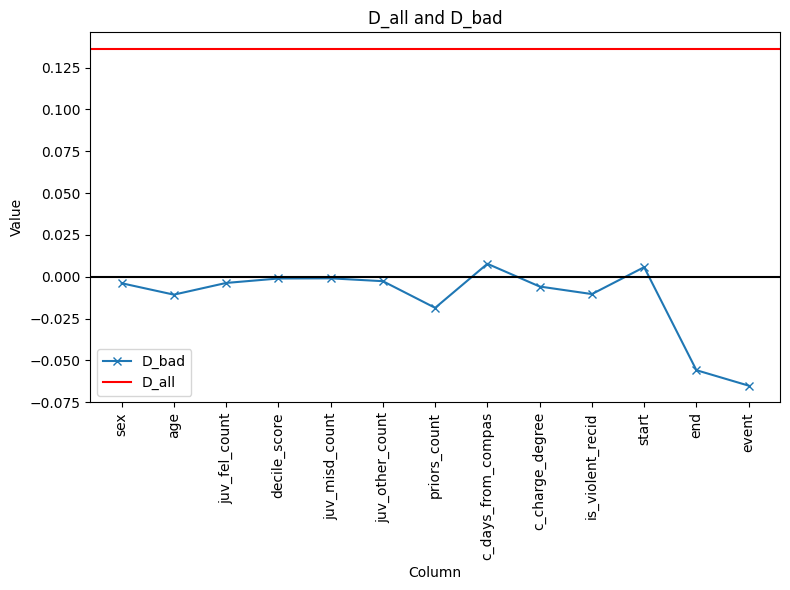

In [84]:
D_all_lm = D_all_func(data = df_lm)
D_bad_lm = D_bad_func(data = df_lm, expl_col=expl, D_all = D_all_lm)
plot_D(D_bad_lm, D_all_base)

$D_{bad}$ decreased after we apply the algorithm. $D_{bad}$ for some of the columns are very close to zero.

Absolute value of `D_bad` decreased significantly compare to our baseline.



In [89]:
# Accuracy of local massaging
X_lm, Y_lm = df_lm.drop("two_year_recid", axis = 1, inplace = False), df_lm.two_year_recid
X_lm_1 = X_lm[X_lm['race'] == 1]
X_lm_0 = X_lm[X_lm['race'] == 0]
Y_lm_1 = df_lm.two_year_recid[df_lm['race'] == 1]
Y_lm_0 = df_lm.two_year_recid[df_lm['race'] == 0]
X_lm = scaler.fit_transform(X_lm)
X_lm_1 = scaler.fit_transform(X_lm_1)
X_lm_0 = scaler.fit_transform(X_lm_0)

preds_all_lm = baseline.predict(X_lm)
accuracy_lm = sum(Y_lm == preds_all_lm)/len(Y_lm)
preds_1_lm = baseline.predict(X_lm_1)
accuracy_lm_1 = sum(Y_lm_1 == preds_1_lm)/len(Y_lm_1)
preds_0_lm = baseline.predict(X_lm_0)
accuracy_lm_0 = sum(Y_lm_0 == preds_0_lm)/len(Y_lm_0)


print("Accuracy: %f" % (accuracy_base))
print("LM Accuracy: %f" % (accuracy_lm))
print("LM Accuracy of African-American: %f" % (accuracy_lm_0))
print("LM Accuracy of Caucasian: %f" % (accuracy_lm_1))

Accuracy: 0.929860
LM Accuracy: 0.811585
LM Accuracy of African-American: 0.802587
LM Accuracy of Caucasian: 0.818137


## *Local preferential sampling*

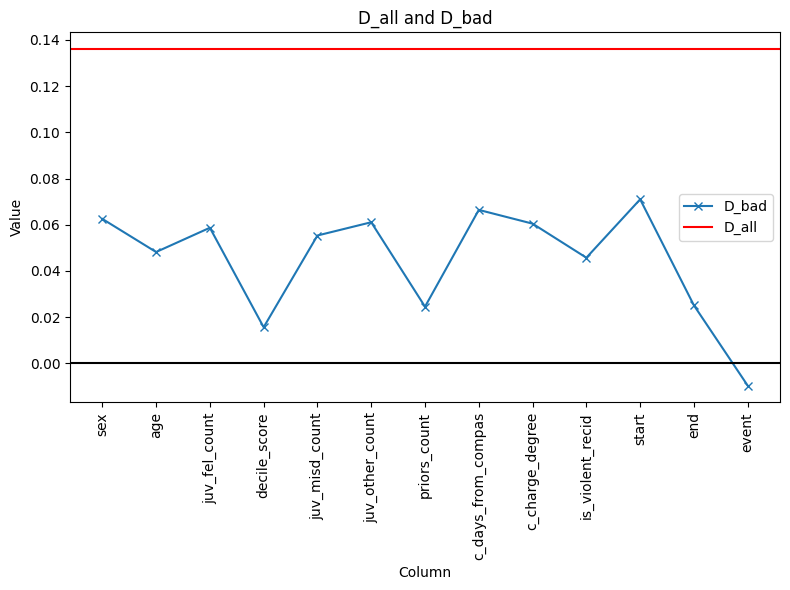

In [90]:
D_all_lps = D_all_func(data = df_lp)
D_bad_lps = D_bad_func(data = df_lp, expl_col=expl, D_all = D_all_lps)
plot_D(D_bad_lps, D_all_base)

As we can see from the plot, the $D_{bad}$ decrease after we apply the algorithm. However, the decreasing seems to be limited.

In [91]:
# Accuracy of LPS
X_lps, y_lps = df_lp.drop("two_year_recid", axis = 1, inplace = False), df_lp.two_year_recid
X_lps_1 = X_lps[X_lps['race'] == 1]
X_lps_0 = X_lps[X_lps['race'] == 0]
y_lps_1 = df_lp.two_year_recid[df_lp['race'] == 1]
y_lps_0 = df_lp.two_year_recid[df_lp['race'] == 0]
X_lps = scaler.fit_transform(X_lps)
X_lps_1 = scaler.fit_transform(X_lps_1)
X_lps_0 = scaler.fit_transform(X_lps_0)

preds_all_lps = baseline.predict(X_lps)
accuracy_lps = sum(y_lps == preds_all_lps)/len(y_lps)
preds_1_lps = baseline.predict(X_lps_1)
accuracy_lps_1 = sum(y_lps_1 == preds_1_lps)/len(y_lps_1)
preds_0_lps = baseline.predict(X_lps_0)
accuracy_lps_0 = sum(y_lps_0 == preds_0_lps)/len(y_lps_0)


print("Baseline Accuracy: %f" % (accuracy_base))
print("LPS Accuracy: %f" % (accuracy_lps))
print("LPS Accuracy of African-American: %f" % (accuracy_lps_0))
print("LPS Accuracy of Caucasian: %f" % (accuracy_lps_1))

Baseline Accuracy: 0.929860
LPS Accuracy: 0.928042
LPS Accuracy of African-American: 0.923758
LPS Accuracy of Caucasian: 0.942467


### Conclusion

The Local messiaging method preform better in reducing the $D_{bad}$, but the amount of decreasing in accuracy is larger. Hence, if one want keep the $D_{all}$ but do not want to reduce the accuracy too much, they may want to choose the local preferential sampling. But if they want to reduce $D_{all}$ as much as possible, they will prefer local messiaging.